# Loading the required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

## Logistic Regression model

In [2]:
# Define a LogisticRegression class for binary classification
class LogisticRegression:
    def __init__(self):
        self.w = None  # Initialize model weights to None

    def predict(self, X):
        """
        Predict binary class labels (0 or 1) based on input features.

        :param X: Input feature matrix.
        :return: Binary predictions.
        """
        ones_column = np.ones((X.shape[0], 1))  # Add a bias column
        X_with_bias = np.concatenate((ones_column, X), axis=1)  # Add bias term to input
        return (np.dot(X_with_bias, self.w)) > 0  # Predict based on dot product with model weights

    def sigmoid(self, z):
        """
        Calculate the sigmoid function.

        :param z: Input values.
        :return: Sigmoid function output.
        """
        return 1 / (1 + np.exp(-z))  # Calculate sigmoid of input

    def fit(self, X, y, learning_rate=0.001, e=0.001, max_iter=200000):
        """
        Train the logistic regression model using gradient descent.

        :param X: Input feature matrix.
        :param y: True binary labels (0 or 1).
        :param learning_rate: Learning rate for gradient descent (default: 0.001).
        :param e: Convergence threshold (default: 0.001).
        :param max_iter: Maximum number of iterations (default: 200,000).
        """
        if self.w is None:  # If weights are None, initialize them based on the number of features
            num_features = X.shape[1]
            self.w = np.zeros(num_features + 1)

        ones_column = np.ones((X.shape[0], 1))  # Add a bias column
        X_with_bias = np.concatenate((ones_column, X), axis=1)  # Add bias term to input
        old_w = np.ones(self.w.shape)
        while np.linalg.norm(self.w - old_w, ord=2) > e and max_iter > 0:
            old_w = self.w.copy()
            predictions = self.sigmoid(np.dot(X_with_bias, self.w))  # Calculate predicted probabilities
            gradient = np.dot(X_with_bias.T, (y - predictions))  # Compute gradient
            self.w += learning_rate * gradient  # Update model weights using gradient descent
            max_iter -= 1
        return

## Train test split function

In [3]:
def my_train_test_split(data, labels, test_size=0.2, random_state=None):
    """
    Custom train-test split function for data and labels.

    :param data: Input data (features).
    :param labels: Corresponding labels.
    :param test_size: Fraction of the data to be allocated as the test set (default: 0.2).
    :param random_state: Seed for random number generation (default: None).

    :return: X_train, X_test, y_train, y_test
    """
    assert len(data) == len(labels), "Data and labels must have the same length!"  # Ensure data and labels have the same length

    if random_state is not None:
        random.seed(random_state)  # Set a random seed if provided

    # Shuffle indices.
    indices = list(data.index)
    random.shuffle(indices)  # Shuffle the indices randomly

    random.seed(10)  # Reset the random seed (not needed)
    random.shuffle(indices)  # Shuffle the indices again (possibly redundant)

    # Calculate the split index based on the test_size fraction.
    split_idx = int(len(data) * (1 - test_size))

    # Split the data and labels based on the calculated indices.
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]

    # Create training and testing sets using the selected indices.
    X_train = data.loc[train_indices]
    y_train = labels.loc[train_indices]

    X_test = data.loc[test_indices]
    y_test = labels.loc[test_indices]

    return X_train, X_test, y_train, y_test


## K fold cross validation function

In [4]:
def Accu_eval(true_labels, predictions):
    """
    Calculate the accuracy of classification predictions.

    :param true_labels: True labels or ground truth.
    :param predictions: Predicted labels made by the model.

    :return: Accuracy value (proportion of correct predictions).
    """
    return np.mean(true_labels == predictions)  # Calculate accuracy as the proportion of correct predictions


In [5]:
def k_fold_split(data, k=10, random_state=None):
    """
    Splits the data into k folds for cross-validation.

    Parameters:
    - data: DataFrame of data points.
    - k: Number of folds.
    - random_state: Seed for random number generator.

    Returns:
    - folds: List of k DataFrames.
    """

    if random_state is not None:
        np.random.seed(random_state)

    # Randomly shuffle the data
    shuffled_data = data.sample(frac=1, random_state=random_state).reset_index(
        drop=True
    )

    # Split the data into k roughly equal parts
    n = len(shuffled_data)
    fold_size = n // k
    folds = []
    for i in range(k):
        if i < k - 1:
            fold = shuffled_data.iloc[i * fold_size : (i + 1) * fold_size]
        else:
            # The last fold might have more than fold_size elements
            fold = shuffled_data.iloc[i * fold_size :]
        folds.append(fold)

    return folds


def k_fold_cross_validation(model, data, labels, k=10, random_state=None):
    """
    Conducts k-fold cross-validation on the data with the given model.

    Parameters:
    - model: A machine learning model with fit and predict methods.
    - data: DataFrame of data points.
    - labels: DataFrame or Series of labels corresponding to the data.
    - k: Number of folds.
    - random_state: Seed for random number generator.

    Returns:
    - scores: List of accuracy scores for each fold.
    """

    data_folds = k_fold_split(data, k, random_state)
    label_folds = k_fold_split(labels, k, random_state)

    scores = []

    for i in range(k):
        # Split the data into training and validation sets
        train_data = pd.concat(
            [fold for j, fold in enumerate(data_folds) if j != i], ignore_index=True
        )
        train_labels = pd.concat(
            [fold for j, fold in enumerate(label_folds) if j != i], ignore_index=True
        )

        validation_data = data_folds[i]
        validation_labels = label_folds[i]

        # Train the model
        model.fit(train_data, train_labels)

        # Predict on the validation set
        predictions = model.predict(validation_data)

        # Calculate accuracy
        accuracy = Accu_eval(validation_labels, predictions)
        scores.append(accuracy)

    return scores, model


## RFE function

In [6]:
def rfe(Model_Class, X, y, train_test_split):
    """
    Perform Recursive Feature Elimination (RFE) to rank and select features.

    Parameters:
    - Model_Class: A machine learning model class with fit and predict methods.
    - X: Input features (DataFrame or array-like).
    - y: Target labels.
    - train_test_split: A function for splitting the data into training and testing sets.

    Returns:
    - weights_ordered_descending: A dictionary of feature names ordered by importance (descending).
    """

    X = X.copy()  # Create a copy of the input features
    weights_ordered = dict()  # Initialize a dictionary to store feature weights

    while True:
        # Split the data into a training set (80%) and an unused test set (20%)
        X_train, _, y_train, _ = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Create an instance of the provided machine learning model
        model = Model_Class()

        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Get the feature weights (excluding the bias)
        weights = model.w[1:]

        # Find the index of the smallest weight
        smallest_weight_index = np.argmin(weights)

        # Get the name of the feature with the smallest weight
        smallest_weight_name = X.columns[smallest_weight_index]

        # Drop the feature with the smallest weight from the dataset
        X = X.drop(columns=smallest_weight_name)

        # Store the name and length of remaining features
        weights_ordered[smallest_weight_name] = len(weights)

        # If only one feature remains, exit the loop
        if len(weights) == 1:
            break

    # Sort the feature names by their lengths (importance) in descending order
    weights_ordered_descending = dict(sorted(weights_ordered.items(), key=lambda item: item[1], reverse=True))

    return weights_ordered_descending


# Data Loading

In [7]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/ML Colab Notebooks/Mushroom.csv"

Mounted at /content/drive


In [8]:
# file_path = "C:/Users/futaba/Downloads/Mushroom.csv"

In [9]:
columns = [
    "Poisonous",
    "Cap-shape",
    "Cap-surface",
    "Cap-color",
    "Bruises",
    "Odor",
    "Gill-attachment",
    "Gill-spacing",
    "Gill-size",
    "Gill-color",
    "Stalk-color-below-ring",
    "Y"
]
df = pd.read_csv(file_path, header=None, names=columns)

# Getting familiar with the data and data visualization

In [10]:
df.head()

,Poisonous,Cap-shape,Cap-surface,Cap-color,Bruises,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-color-below-ring,Y
0,0.24779,0.35274,0.10,0.102740,0.113520,0.211270,0.095406,0.53485,0.66142,0.21557,0.36923,1
1,0.19469,0.32192,0.06,0.349320,0.080134,0.140850,0.042403,0.44974,0.52756,0.15569,0.36923,1
2,0.19469,0.32192,0.06,0.349320,0.080134,0.140850,0.042403,0.44974,0.52756,0.15569,0.36923,1
3,0.13274,0.30137,0.00,0.089041,0.111850,0.070423,0.010601,0.34703,0.66929,0.12575,0.47692,1
4,0.24779,0.27397,0.13,0.102740,0.110180,0.464790,0.194350,0.38225,0.54331,0.15569,0.36923,1


## Histogram of features

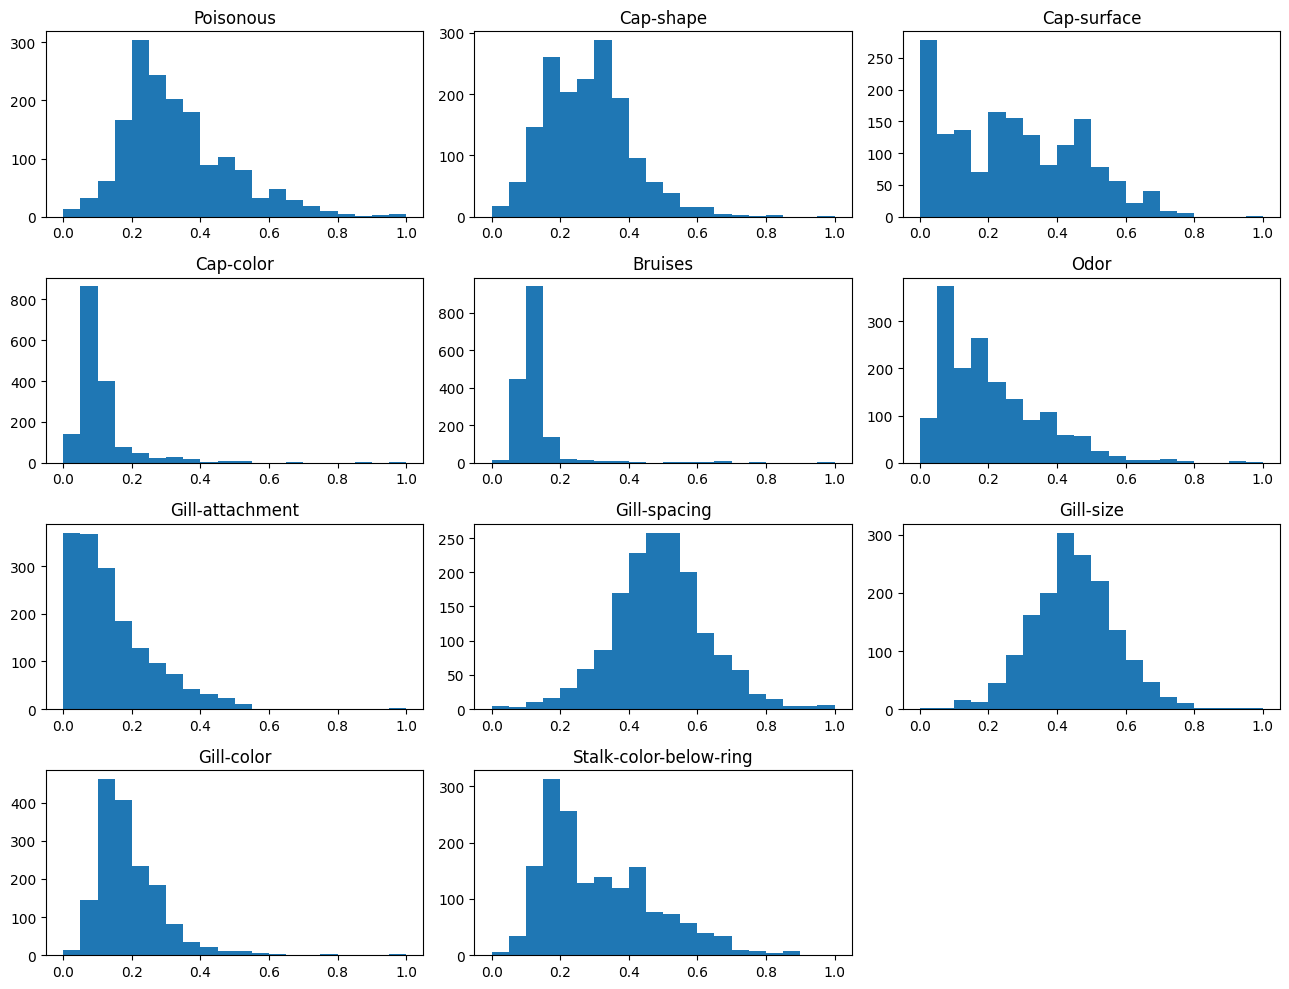

In [11]:
features_columns = columns[:-1]
features = df.loc[:, features_columns]
features.hist(figsize=(13, 10), bins=20, grid=False)
plt.tight_layout()
plt.show()

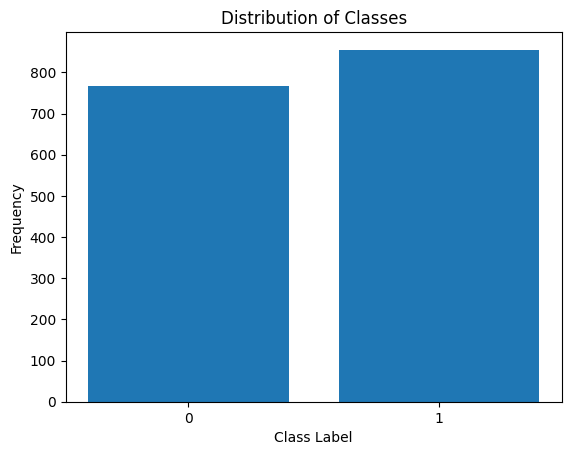

In [12]:
class_data = df.loc[:, "Y"]
unique, counts = np.unique(class_data, return_counts=True)
plt.bar(unique, counts, tick_label=["0", "1"])
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Classes")
plt.show()

## Distribution of features

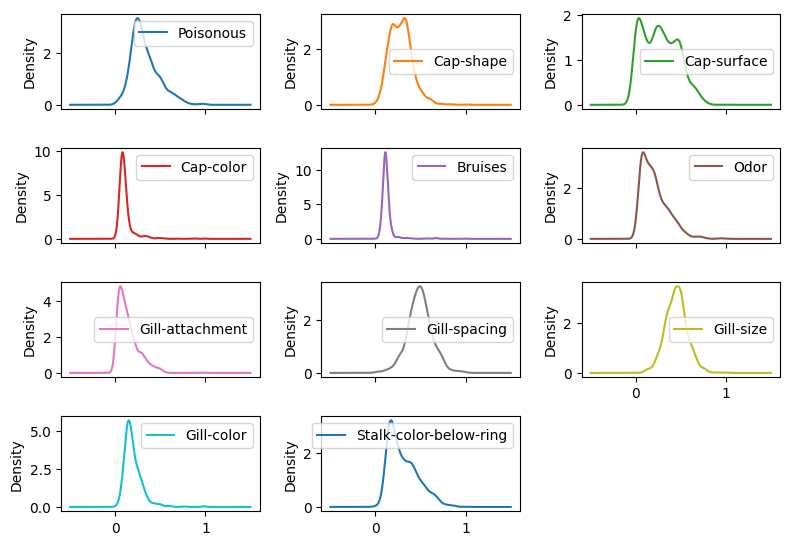

In [13]:
features.plot(kind="density", subplots=True, layout=(6, 3), sharex=True, figsize=(8, 8))
plt.tight_layout()
plt.show()

## Corelation matrix of the features (also with class)

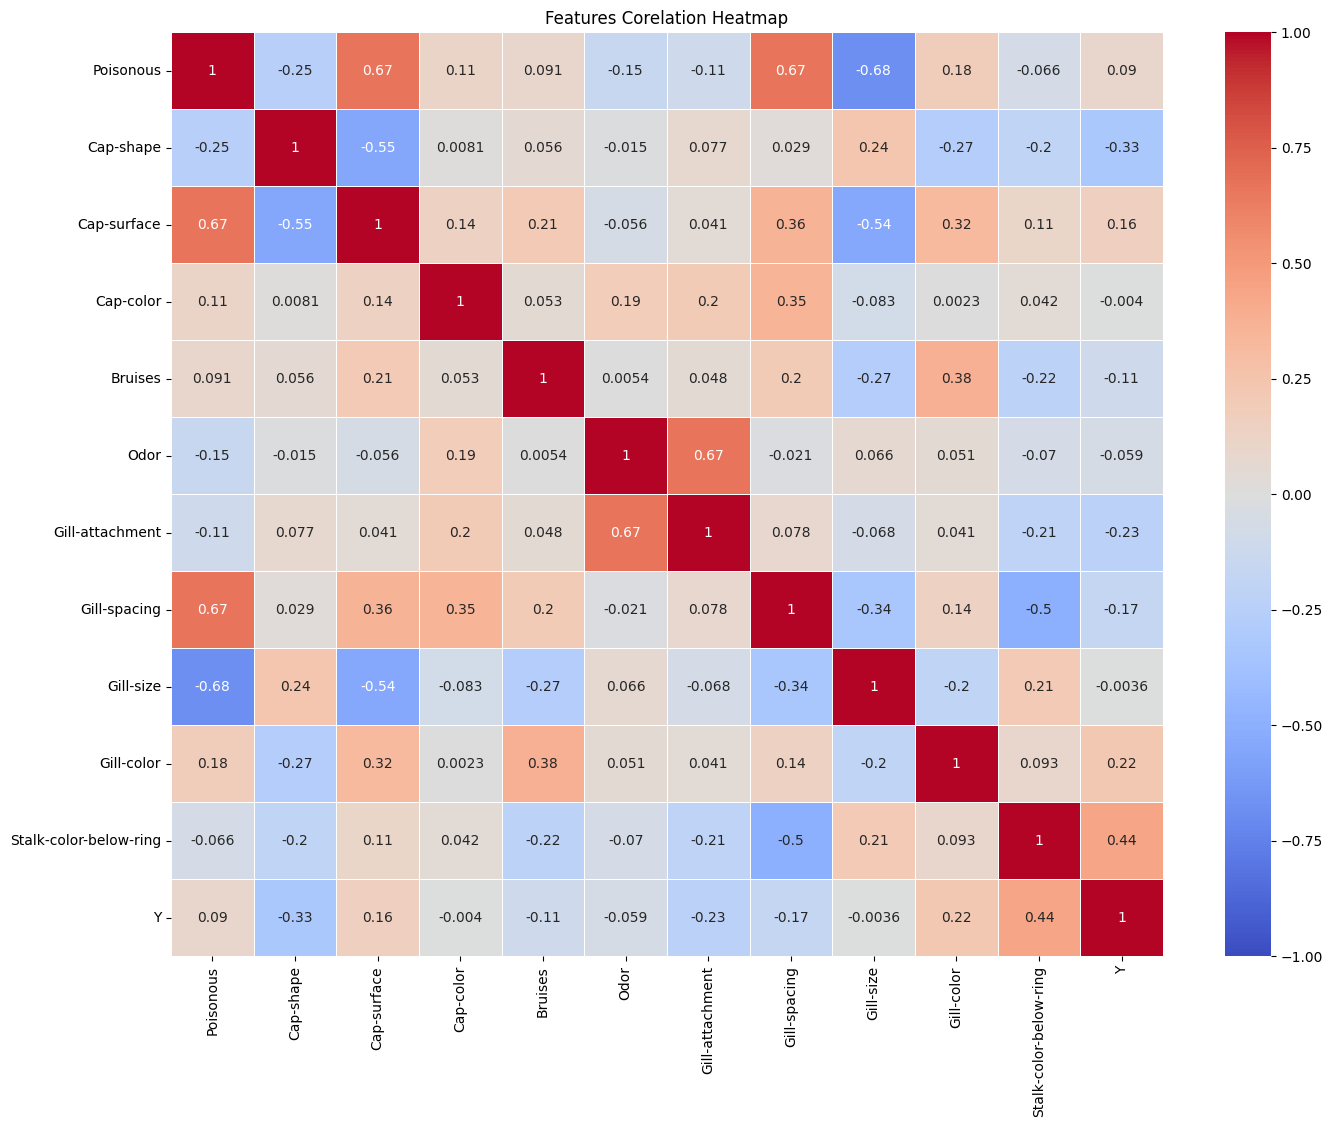

In [14]:
corelation_matrix = df.loc[:, columns].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(
    corelation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1
)
plt.title("Features Corelation Heatmap")
plt.show()

## Pair plot of features (also with class)

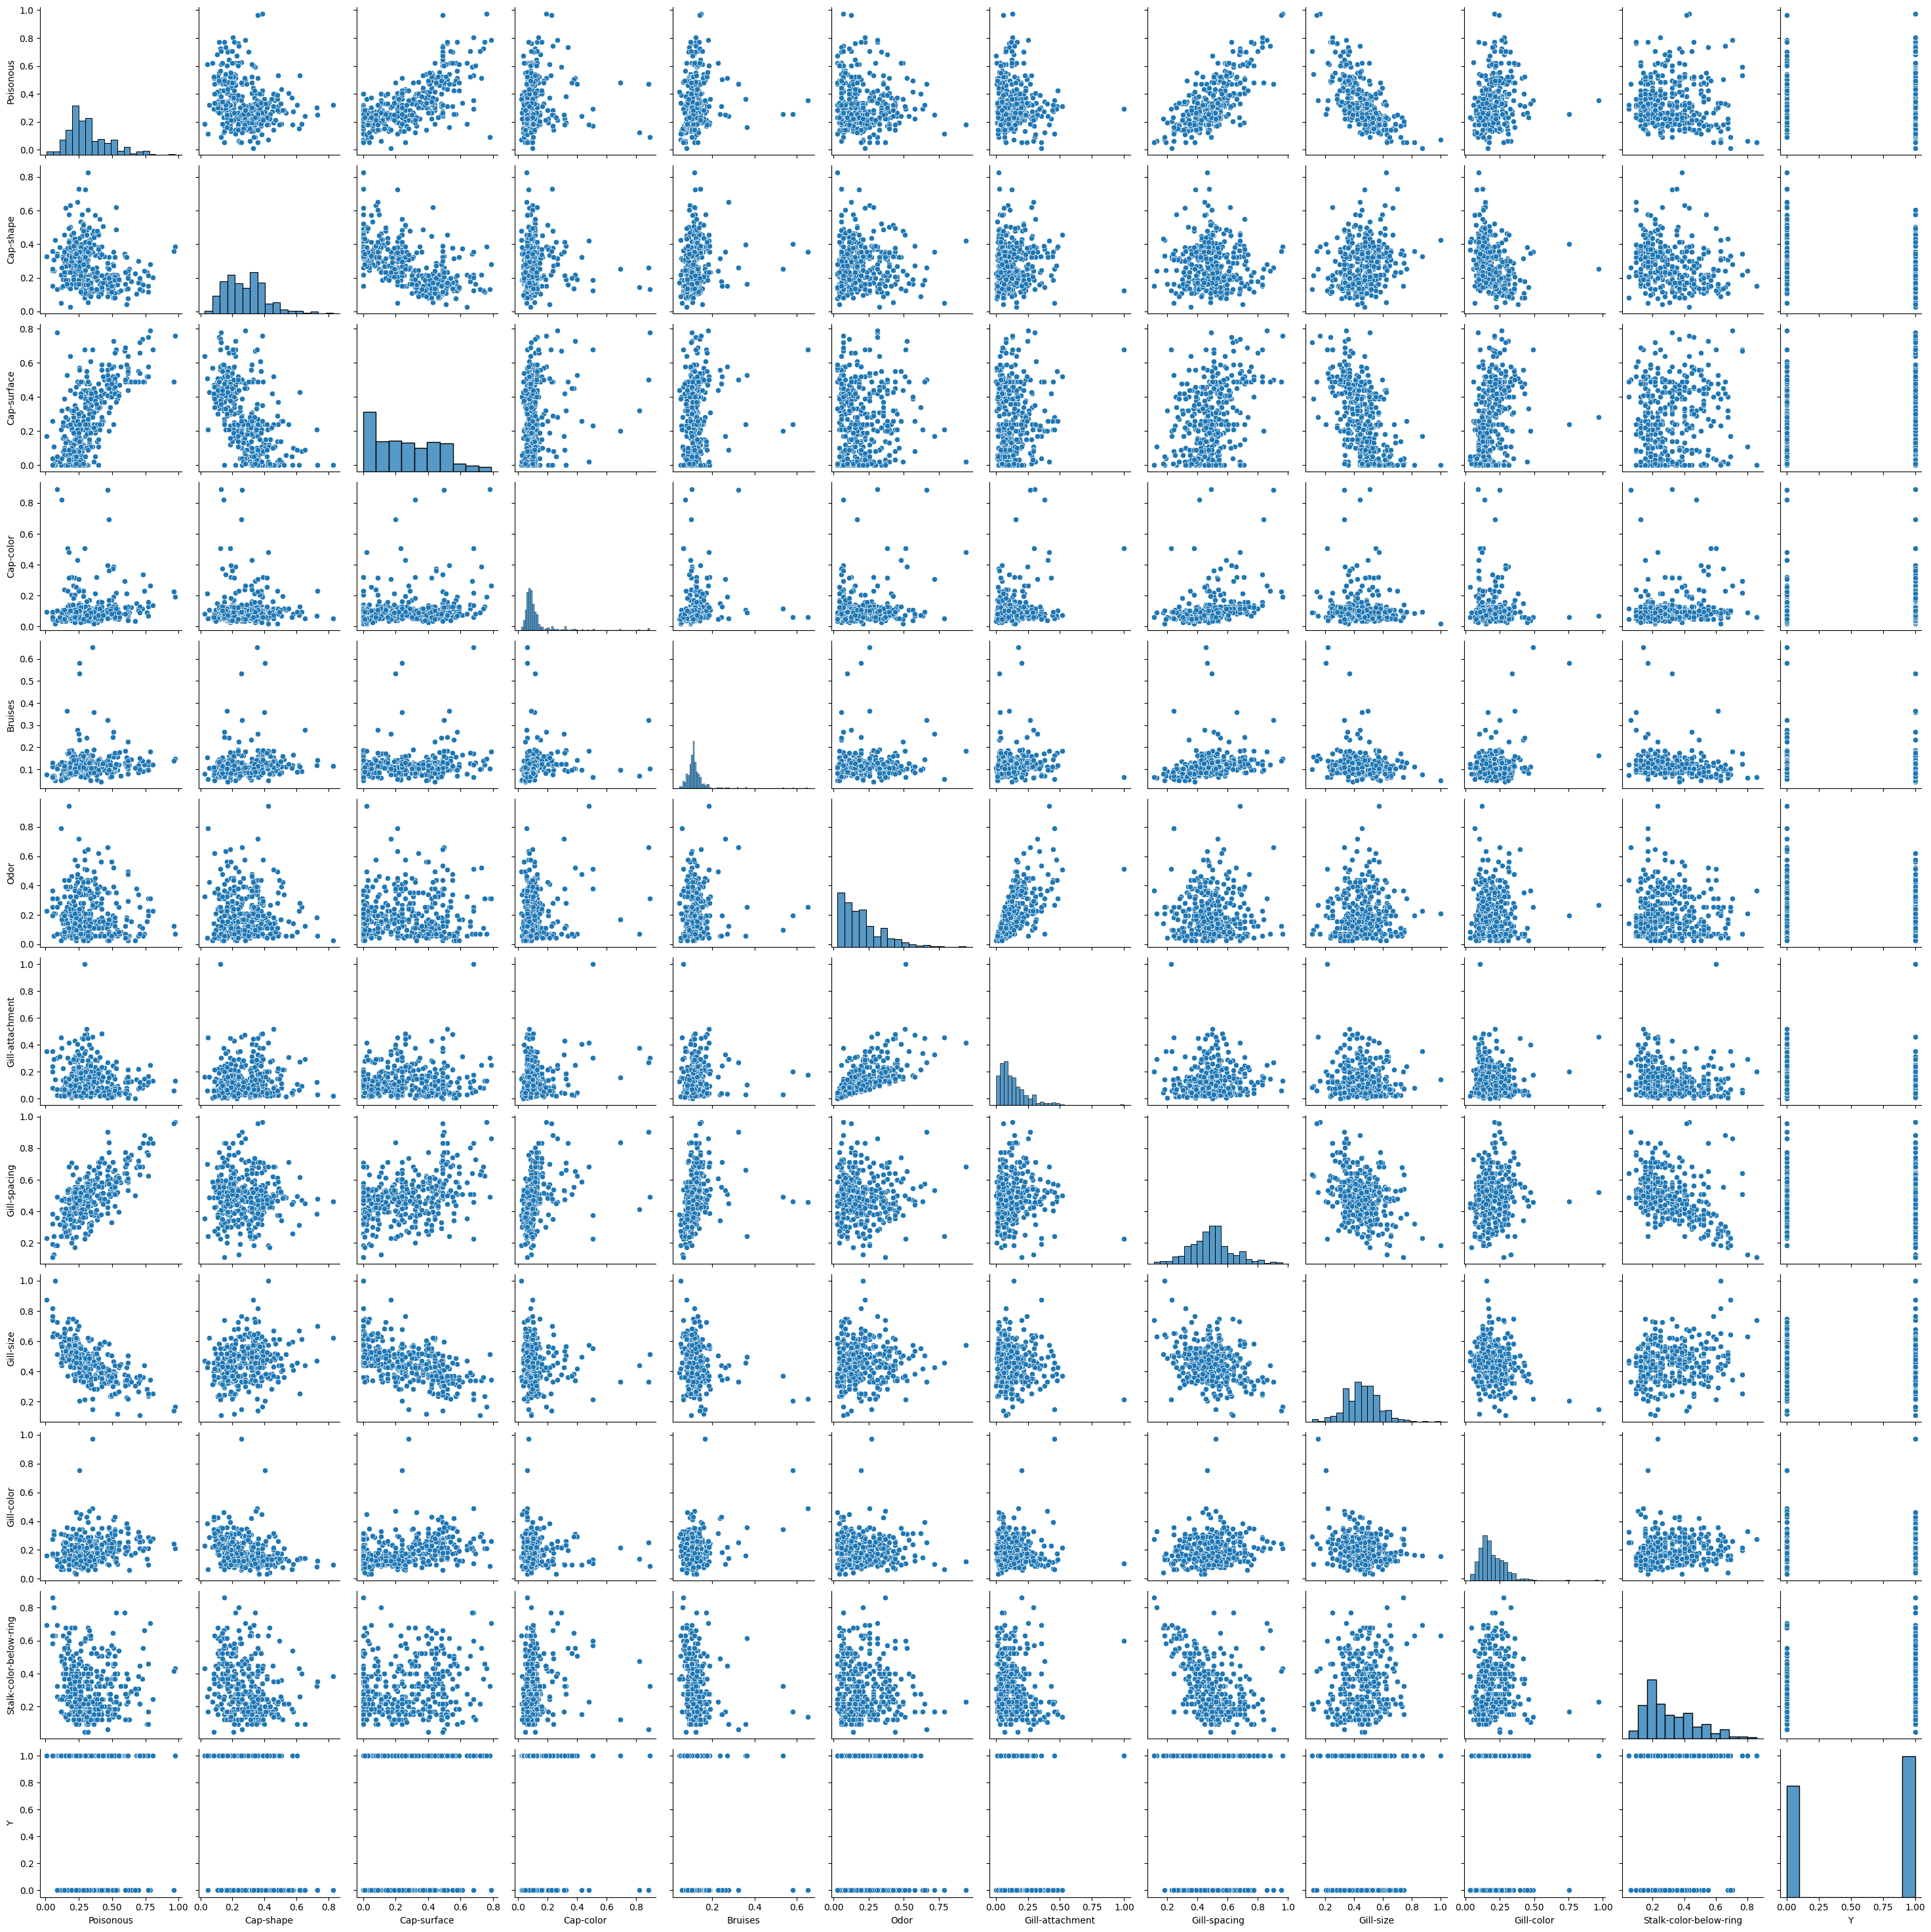

In [15]:
sns.pairplot(
    df.loc[:, columns].sample(frac=0.25)
)  # Here, using a 10% sample for demonstration
plt.show()

## Some statistics on the data

In [16]:
features.describe()

,Poisonous,Cap-shape,Cap-surface,Cap-color,Bruises,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-color-below-ring
count,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000
mean,0.329778,0.280697,0.270924,0.112419,0.126170,0.209289,0.143524,0.491271,0.449740,0.195918,0.309764
std,0.153708,0.123799,0.194365,0.096173,0.079335,0.146923,0.116731,0.138403,0.121337,0.101586,0.163566
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.221240,0.184930,0.090000,0.068493,0.096828,0.084507,0.056537,0.405720,0.370080,0.131740,0.169230
50%,0.292040,0.273970,0.260000,0.089041,0.111850,0.183100,0.113070,0.491560,0.448820,0.173650,0.261540
75%,0.407080,0.356160,0.420000,0.116440,0.130220,0.281690,0.199645,0.572270,0.519690,0.239520,0.415380
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data visualization and statistics of each class (Separately)

### Hepatitis class

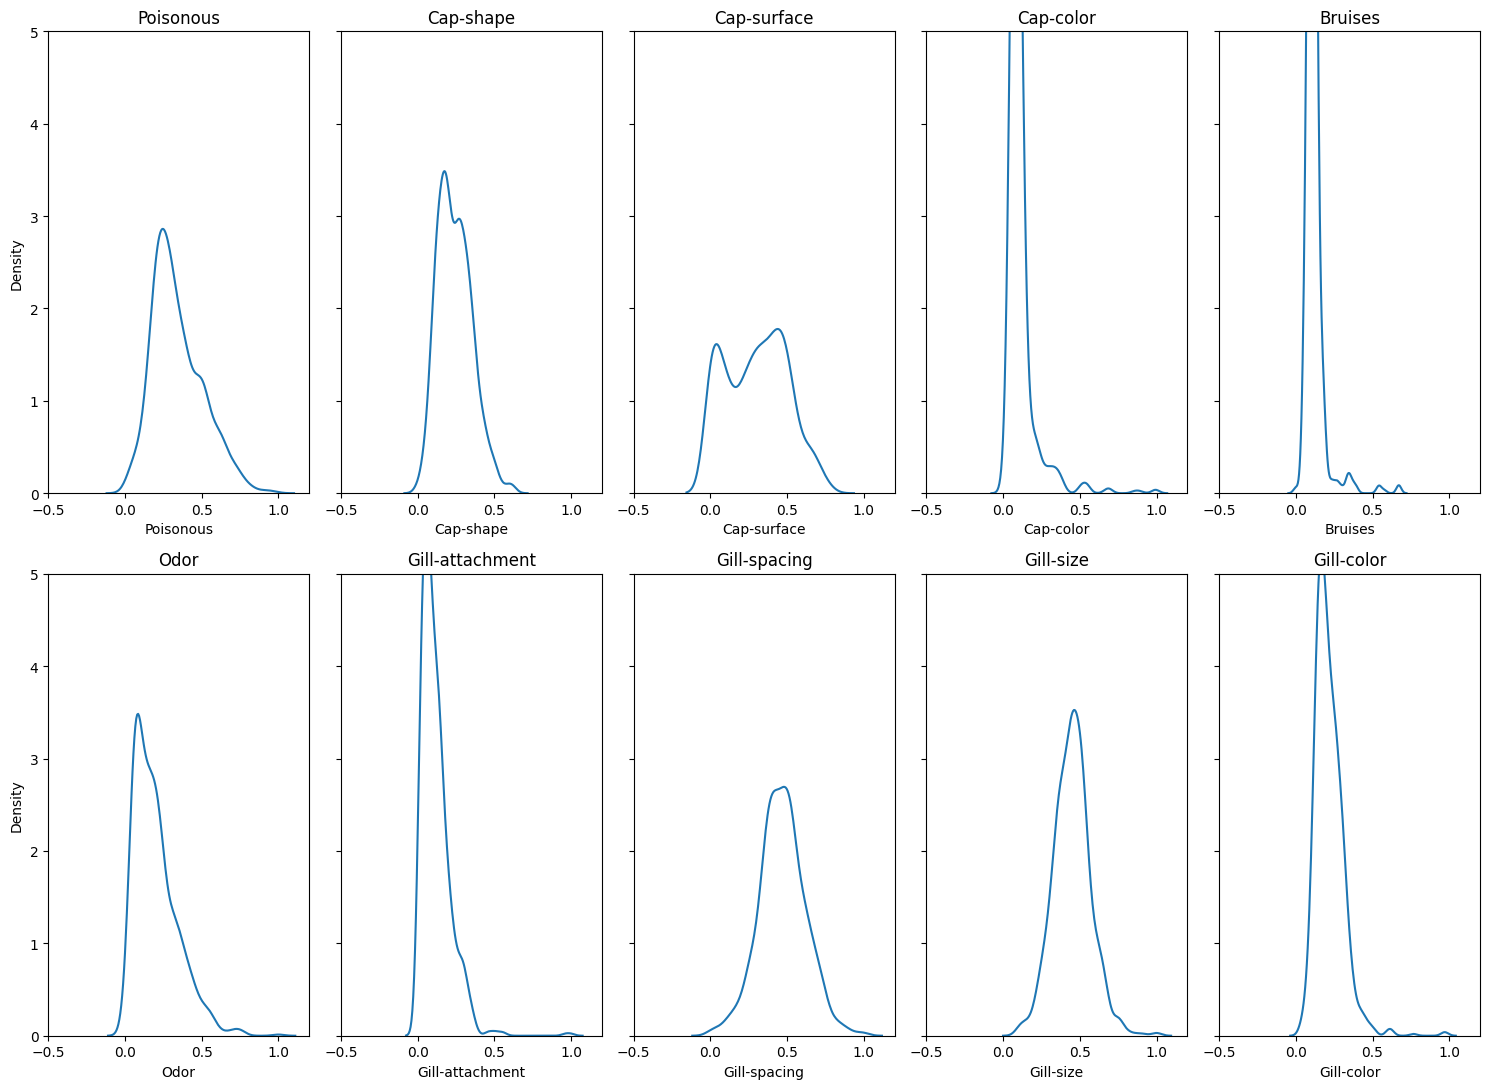

,Poisonous,Cap-shape,Cap-surface,Cap-color,Bruises,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-color-below-ring
count,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000
mean,0.342835,0.242566,0.299883,0.112053,0.117965,0.201022,0.117852,0.469315,0.449325,0.217138,0.377697
std,0.164849,0.110958,0.199889,0.097591,0.062201,0.141388,0.096301,0.151695,0.121696,0.093149,0.170171
min,0.008850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094488,0.035928,0.000000
25%,0.221240,0.157530,0.115000,0.068493,0.091820,0.084507,0.049470,0.375275,0.370080,0.155690,0.246150
50%,0.300880,0.232880,0.310000,0.089041,0.108510,0.169010,0.095406,0.464420,0.448820,0.197600,0.369230
75%,0.446905,0.315070,0.460000,0.116440,0.126045,0.274650,0.155480,0.558695,0.519690,0.263470,0.507690
max,0.973450,0.630140,0.780000,0.993150,0.672790,1.000000,1.000000,1.000000,1.000000,0.970060,0.861540


In [17]:
positive_samples = df[df["Y"] == 1]
positive_samples_without_label = positive_samples.loc[:, features_columns]
fig, axes = plt.subplots(
    2, len(features_columns) // 2, figsize=(15, len(features_columns)), sharey=True
)

# Set global y-axis limits
for row_axes in axes:
    for ax in row_axes:
        ax.set_ylim(0, 5)
        ax.set_xlim(-0.5, 1.2)


for col, ax in zip(features_columns, axes.ravel()):
    sns.kdeplot(positive_samples_without_label[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()
positive_samples_without_label.describe()

### Normal class

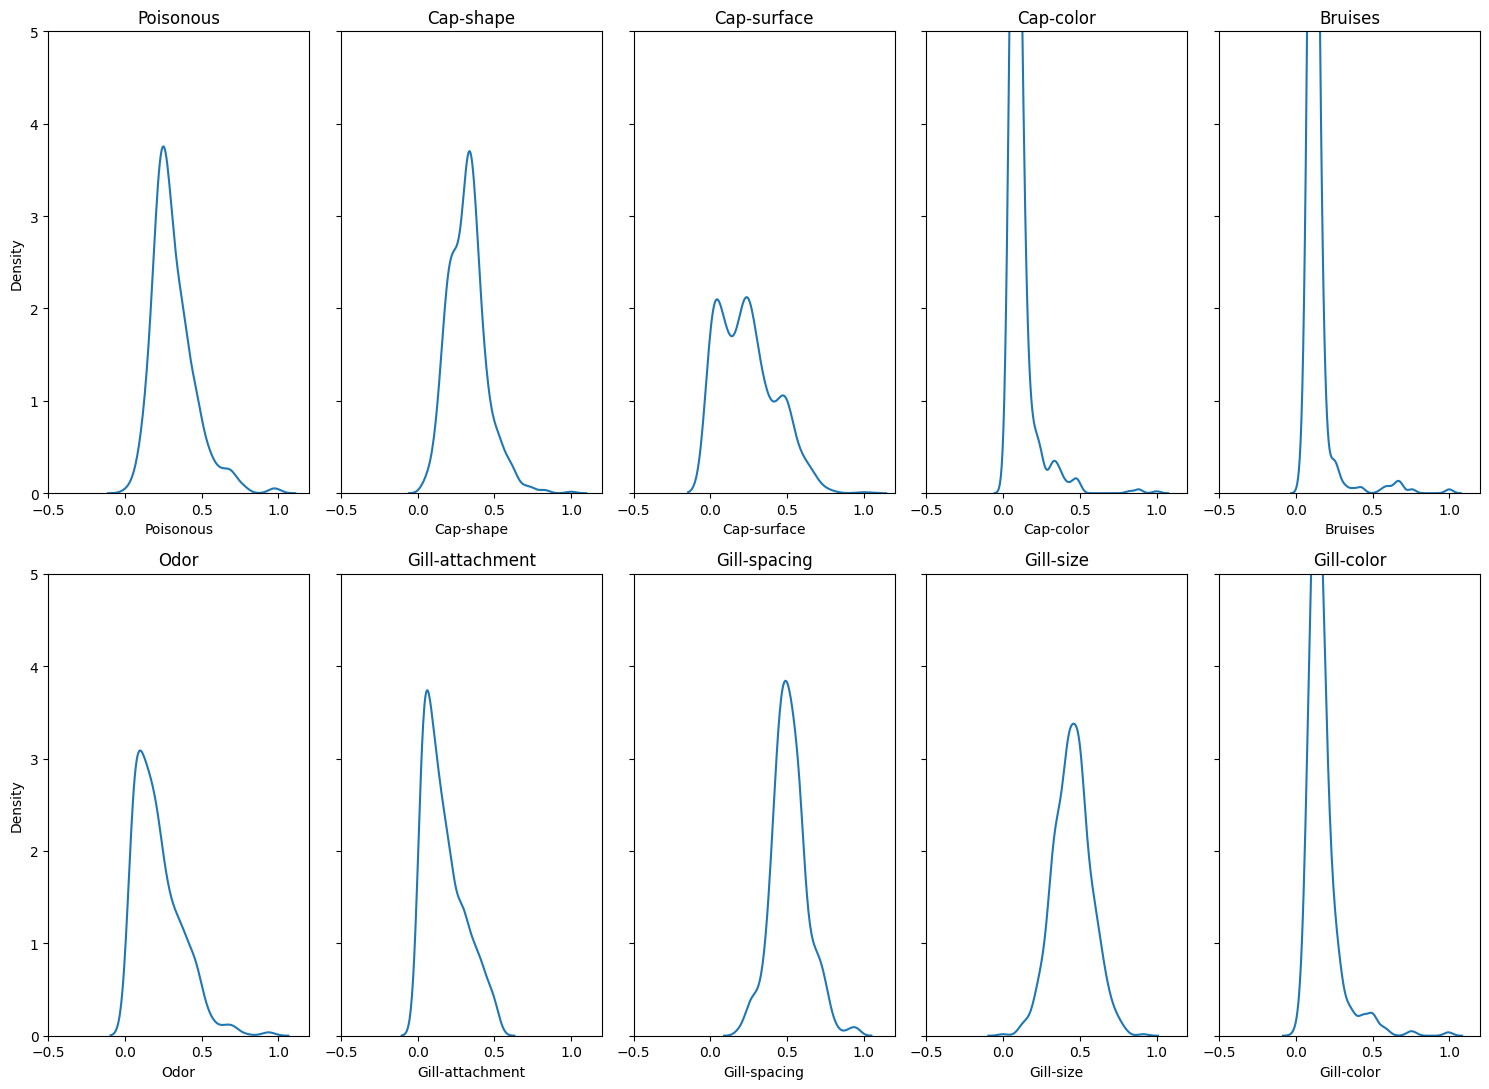

,Poisonous,Cap-shape,Cap-surface,Cap-color,Bruises,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-color-below-ring
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.315243,0.323149,0.238685,0.112827,0.135305,0.218494,0.172105,0.515716,0.450203,0.172295,0.234135
std,0.138938,0.123600,0.182830,0.094632,0.094041,0.152416,0.130142,0.117265,0.121013,0.105366,0.116029
min,0.000000,0.041096,0.000000,0.020548,0.045075,0.028169,0.000000,0.182690,0.000000,0.000000,0.000000
25%,0.221240,0.232880,0.080000,0.068493,0.103510,0.098592,0.060071,0.446810,0.362200,0.113770,0.153850
50%,0.283190,0.321920,0.220000,0.089041,0.115190,0.183100,0.137810,0.508440,0.448820,0.149700,0.200000
75%,0.380530,0.386990,0.360000,0.116440,0.136890,0.309860,0.254420,0.581800,0.519690,0.191620,0.292310
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.943660,0.526500,0.955980,0.913390,1.000000,1.000000


In [18]:
negative_samples = df[df["Y"] == 0]
negative_samples_without_label = negative_samples.loc[:, features_columns]
fig, axes = plt.subplots(
    2, len(features_columns) // 2, figsize=(15, len(features_columns)), sharey=True
)

# Set global y-axis limits
for row_axes in axes:
    for ax in row_axes:
        ax.set_ylim(0, 5)
        ax.set_xlim(-0.5, 1.2)
# Plot each feature's KDE on a separate subplot


for col, ax in zip(features_columns, axes.ravel()):
    sns.kdeplot(negative_samples_without_label[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()
negative_samples_without_label.describe()

# Hepatitis dataset

## feature Selection

### basic features

In [19]:
# First we select all of the given features
all_features = [
    "Poisonous",
    "Cap-shape",
    "Cap-surface",
    "Cap-color",
    "Bruises",
    "Odor",
    "Gill-attachment",
    "Gill-spacing",
    "Gill-size",
    "Gill-color",
    "Stalk-color-below-ring"
]

### Spliting data into train and test data

In [20]:
X = df.loc[:, all_features]
y = df.loc[:, "Y"]
X_train, X_test, y_train, y_test = my_train_test_split(
    X, y, test_size=0.2, random_state=42
)

###  Validating model with cross validation

In [21]:
model = LogisticRegression()
scores, trained_model = k_fold_cross_validation(
    model, X_train, y_train, k=10, random_state=42
)
best_score_mean = np.mean(scores)
print("best score mean: ", best_score_mean)

best score mean:  0.7584450857239857


In [22]:
model = LogisticRegression()
model.fit(X_train, y_train)
print(Accu_eval(y_test, model.predict(X_test)))

0.7046153846153846


In [23]:
weight_importance = rfe(LogisticRegression, X, y, my_train_test_split)
print(weight_importance)

{'Cap-shape': 11, 'Gill-attachment': 10, 'Bruises': 9, 'Gill-spacing': 8, 'Cap-color': 7, 'Gill-size': 6, 'Odor': 5, 'Cap-surface': 4, 'Poisonous': 3, 'Gill-color': 2, 'Stalk-color-below-ring': 1}


### Feature engineering

1. basis expantion (order 2)

In [24]:
# Select the desired features from the DataFrame 'df'
X_engineered = df.loc[:, all_features]

# Initialize an empty DataFrame to store the new squared features
new_features_df = pd.DataFrame()

# Iterate over each feature in 'all_features'
for i in range(len(all_features)):
    # Define a new column name by appending "^2" to the original feature name
    new_col_name = all_features[i] + "^2"

    # Calculate the squared values of the current feature and add it as a new column
    new_features_df[new_col_name] = X_engineered[all_features[i]] ** 2

# If you want to append these new features to the original DataFrame, you can concatenate them
X_engineered = pd.concat([X_engineered, new_features_df], axis=1)

# Display the first few rows of the updated 'X_engineered' DataFrame
X_engineered.head()


,Poisonous,Cap-shape,Cap-surface,Cap-color,Bruises,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,...,Cap-shape^2,Cap-surface^2,Cap-color^2,Bruises^2,Odor^2,Gill-attachment^2,Gill-spacing^2,Gill-size^2,Gill-color^2,Stalk-color-below-ring^2
0,0.24779,0.35274,0.10,0.102740,0.113520,0.211270,0.095406,0.53485,0.66142,0.21557,...,0.124426,0.0100,0.010556,0.012887,0.044635,0.009102,0.286065,0.437476,0.046470,0.136331
1,0.19469,0.32192,0.06,0.349320,0.080134,0.140850,0.042403,0.44974,0.52756,0.15569,...,0.103632,0.0036,0.122024,0.006421,0.019839,0.001798,0.202266,0.278320,0.024239,0.136331
2,0.19469,0.32192,0.06,0.349320,0.080134,0.140850,0.042403,0.44974,0.52756,0.15569,...,0.103632,0.0036,0.122024,0.006421,0.019839,0.001798,0.202266,0.278320,0.024239,0.136331
3,0.13274,0.30137,0.00,0.089041,0.111850,0.070423,0.010601,0.34703,0.66929,0.12575,...,0.090824,0.0000,0.007928,0.012510,0.004959,0.000112,0.120430,0.447949,0.015813,0.227453
4,0.24779,0.27397,0.13,0.102740,0.110180,0.464790,0.194350,0.38225,0.54331,0.15569,...,0.075060,0.0169,0.010556,0.012140,0.216030,0.037772,0.146115,0.295186,0.024239,0.136331


In [25]:
# Split the engineered feature dataset into training and testing sets
X_engineered_train, X_engineered_test, y_train, y_test = my_train_test_split(
    X_engineered, y, test_size=0.2, random_state=42
)

# Instantiate a logistic regression model
model = LogisticRegression()

# Perform k-fold cross-validation on the training data
scores, trained_model = k_fold_cross_validation(
    model, X_engineered_train, y_train, k=10, random_state=42
)

# Calculate the mean of accuracy scores obtained from cross-validation
best_score_mean = np.mean(scores)

# Print the mean accuracy score as the evaluation result
print("best score mean: ", best_score_mean)


best score mean:  0.7575340915520851


In [26]:
model = LogisticRegression()
model.fit(X_engineered_train, y_train)
print(Accu_eval(y_test, model.predict(X_engineered_test)))

0.7015384615384616


In [27]:
weight_importance = rfe(LogisticRegression, X_engineered, y, my_train_test_split)
print(weight_importance)

{'Gill-color^2': 22, 'Cap-shape': 21, 'Cap-shape^2': 20, 'Gill-attachment': 19, 'Gill-attachment^2': 18, 'Bruises': 17, 'Bruises^2': 16, 'Gill-size^2': 15, 'Gill-spacing': 14, 'Cap-surface^2': 13, 'Gill-spacing^2': 12, 'Cap-color': 11, 'Odor^2': 10, 'Gill-size': 9, 'Odor': 8, 'Cap-surface': 7, 'Cap-color^2': 6, 'Poisonous^2': 5, 'Poisonous': 4, 'Stalk-color-below-ring^2': 3, 'Gill-color': 2, 'Stalk-color-below-ring': 1}


2. basis expantion (order 3)

In [28]:
# Create a new dataframe 'new_features_df' to store cubed features
new_features_df = pd.DataFrame()

# Iterate through each feature in 'all_features'
for i in range(len(all_features)):
    # Generate a new column name for cubed features
    new_col_name = all_features[i] + "^3"

    # Calculate and add cubed values as a new column in 'new_features_df'
    new_features_df[new_col_name] = X_engineered[all_features[i]] ** 3

# Append the newly created cubed features to the original dataframe 'X_engineered'
X_engineered = pd.concat([X_engineered, new_features_df], axis=1)

# Display the first few rows of the updated 'X_engineered' dataframe
X_engineered.head()


,Poisonous,Cap-shape,Cap-surface,Cap-color,Bruises,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,...,Cap-shape^3,Cap-surface^3,Cap-color^3,Bruises^3,Odor^3,Gill-attachment^3,Gill-spacing^3,Gill-size^3,Gill-color^3,Stalk-color-below-ring^3
0,0.24779,0.35274,0.10,0.102740,0.113520,0.211270,0.095406,0.53485,0.66142,0.21557,...,0.043890,0.001000,0.001084,0.001463,0.009430,0.000868,0.153002,0.289356,0.010018,0.050337
1,0.19469,0.32192,0.06,0.349320,0.080134,0.140850,0.042403,0.44974,0.52756,0.15569,...,0.033361,0.000216,0.042626,0.000515,0.002794,0.000076,0.090967,0.146830,0.003774,0.050337
2,0.19469,0.32192,0.06,0.349320,0.080134,0.140850,0.042403,0.44974,0.52756,0.15569,...,0.033361,0.000216,0.042626,0.000515,0.002794,0.000076,0.090967,0.146830,0.003774,0.050337
3,0.13274,0.30137,0.00,0.089041,0.111850,0.070423,0.010601,0.34703,0.66929,0.12575,...,0.027372,0.000000,0.000706,0.001399,0.000349,0.000001,0.041793,0.299808,0.001988,0.108477
4,0.24779,0.27397,0.13,0.102740,0.110180,0.464790,0.194350,0.38225,0.54331,0.15569,...,0.020564,0.002197,0.001084,0.001338,0.100408,0.007341,0.055852,0.160377,0.003774,0.050337


In [29]:
# Split the engineered feature dataset into training and testing sets
X_engineered_train, X_engineered_test, y_train, y_test = my_train_test_split(
    X_engineered, y, test_size=0.2, random_state=42
)

# Instantiate a logistic regression model
model = LogisticRegression()

# Perform k-fold cross-validation on the training data
scores, trained_model = k_fold_cross_validation(
    model, X_engineered_train, y_train, k=10, random_state=42
)

# Calculate the mean of accuracy scores obtained from cross-validation
best_score_mean = np.mean(scores)

# Print the mean accuracy score as the evaluation result
print("best score mean: ", best_score_mean)


best score mean:  0.7598144061562836


In [30]:
model = LogisticRegression()
model.fit(X_engineered_train, y_train)
print(Accu_eval(y_test, model.predict(X_engineered_test)))

0.7015384615384616


In [31]:
weight_importance = rfe(LogisticRegression, X_engineered, y, my_train_test_split)
print(weight_importance)

{'Gill-attachment': 33, 'Gill-attachment^2': 32, 'Cap-shape': 31, 'Cap-shape^2': 30, 'Cap-shape^3': 29, 'Gill-color^3': 28, 'Gill-color^2': 27, 'Gill-attachment^3': 26, 'Gill-size^3': 25, 'Bruises': 24, 'Bruises^2': 23, 'Bruises^3': 22, 'Stalk-color-below-ring^3': 21, 'Cap-surface^3': 20, 'Gill-size^2': 19, 'Gill-spacing': 18, 'Cap-color': 17, 'Gill-spacing^2': 16, 'Gill-spacing^3': 15, 'Cap-surface^2': 14, 'Odor^2': 13, 'Odor^3': 12, 'Odor': 11, 'Cap-surface': 10, 'Poisonous^3': 9, 'Gill-size': 8, 'Cap-color^2': 7, 'Cap-color^3': 6, 'Poisonous^2': 5, 'Poisonous': 4, 'Stalk-color-below-ring^2': 3, 'Gill-color': 2, 'Stalk-color-below-ring': 1}


3. interaction terms

In [32]:
# Create a new dataframe 'new_features_df' to store interaction features
new_features_df = pd.DataFrame()

# Iterate through each pair of features in 'all_features'
for i in range(len(all_features)):
    for j in range(i + 1, len(all_features)):
        # Generate a new column name for interaction features
        new_col_name = all_features[i] + "X" + all_features[j]

        # Calculate and add interaction values as a new column in 'new_features_df'
        new_features_df[new_col_name] = (
            X_engineered[all_features[i]] * X_engineered[all_features[j]]
        )

# Append the newly created interaction features to the original dataframe 'X_engineered'
X_engineered = pd.concat([X_engineered, new_features_df], axis=1)

# Update the 'selected_features' list with the new interaction features
X_engineered.head()


,Poisonous,Cap-shape,Cap-surface,Cap-color,Bruises,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,...,Gill-attachmentXGill-spacing,Gill-attachmentXGill-size,Gill-attachmentXGill-color,Gill-attachmentXStalk-color-below-ring,Gill-spacingXGill-size,Gill-spacingXGill-color,Gill-spacingXStalk-color-below-ring,Gill-sizeXGill-color,Gill-sizeXStalk-color-below-ring,Gill-colorXStalk-color-below-ring
0,0.24779,0.35274,0.10,0.102740,0.113520,0.211270,0.095406,0.53485,0.66142,0.21557,...,0.051028,0.063103,0.020567,0.035227,0.353760,0.115298,0.197483,0.142582,0.244216,0.079595
1,0.19469,0.32192,0.06,0.349320,0.080134,0.140850,0.042403,0.44974,0.52756,0.15569,...,0.019070,0.022370,0.006602,0.015656,0.237265,0.070020,0.166058,0.082136,0.194791,0.057485
2,0.19469,0.32192,0.06,0.349320,0.080134,0.140850,0.042403,0.44974,0.52756,0.15569,...,0.019070,0.022370,0.006602,0.015656,0.237265,0.070020,0.166058,0.082136,0.194791,0.057485
3,0.13274,0.30137,0.00,0.089041,0.111850,0.070423,0.010601,0.34703,0.66929,0.12575,...,0.003679,0.007095,0.001333,0.005056,0.232264,0.043639,0.165506,0.084163,0.319198,0.059973
4,0.24779,0.27397,0.13,0.102740,0.110180,0.464790,0.194350,0.38225,0.54331,0.15569,...,0.074290,0.105592,0.030258,0.071760,0.207680,0.059513,0.141138,0.084588,0.200606,0.057485


In [33]:
# Split the engineered feature dataset into training and testing sets
X_engineered_train, X_engineered_test, y_train, y_test = my_train_test_split(
    X_engineered, y, test_size=0.2, random_state=42
)

# Instantiate a logistic regression model
model = LogisticRegression()

# Perform k-fold cross-validation on the training data (using 10 folds for illustration)
# Note: The code mentions using 10 folds but actually uses 5 for the sake of time
scores, trained_model = k_fold_cross_validation(
    model, X_engineered_train, y_train, k=10, random_state=42
)

# Calculate the mean of accuracy scores obtained from cross-validation
best_score_mean = np.mean(scores)

# Print the mean accuracy score as the evaluation result
print("best score mean: ", best_score_mean)


best score mean:  0.7658348893792791


In [34]:
model = LogisticRegression()
model.fit(X_engineered_train, y_train)
print(Accu_eval(y_test, model.predict(X_engineered_test)))

0.72


In [35]:
weight_importance = rfe(LogisticRegression, X_engineered, y, my_train_test_split)
print(weight_importance)

{'Gill-attachmentXGill-spacing': 88, 'Cap-surfaceXGill-spacing': 87, 'Cap-shape': 86, 'Cap-surfaceXCap-color': 85, 'Odor^2': 84, 'OdorXGill-attachment': 83, 'Odor^3': 82, 'OdorXGill-spacing': 81, 'PoisonousXStalk-color-below-ring': 80, 'Gill-spacingXStalk-color-below-ring': 79, 'Cap-shapeXGill-spacing': 78, 'PoisonousXCap-shape': 77, 'Cap-shape^2': 76, 'Cap-shapeXGill-size': 75, 'Cap-shape^3': 74, 'Cap-shapeXStalk-color-below-ring': 73, 'Cap-shapeXOdor': 72, 'Cap-shapeXGill-color': 71, 'Cap-shapeXCap-surface': 70, 'Cap-shapeXGill-attachment': 69, 'Cap-shapeXBruises': 68, 'Cap-shapeXCap-color': 67, 'Gill-attachment': 66, 'PoisonousXGill-attachment': 65, 'Gill-attachmentXGill-size': 64, 'Gill-attachment^2': 63, 'Gill-attachmentXGill-color': 62, 'Cap-surfaceXGill-attachment': 61, 'BruisesXGill-attachment': 60, 'Gill-attachmentXStalk-color-below-ring': 59, 'PoisonousXOdor': 58, 'Gill-color^2': 57, 'Gill-color^3': 56, 'BruisesXOdor': 55, 'OdorXGill-color': 54, 'Cap-surfaceXOdor': 53, 'Odor'

In [36]:
X_engineered.head()
X_engineered.describe()

,Poisonous,Cap-shape,Cap-surface,Cap-color,Bruises,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,...,Gill-attachmentXGill-spacing,Gill-attachmentXGill-size,Gill-attachmentXGill-color,Gill-attachmentXStalk-color-below-ring,Gill-spacingXGill-size,Gill-spacingXGill-color,Gill-spacingXStalk-color-below-ring,Gill-sizeXGill-color,Gill-sizeXStalk-color-below-ring,Gill-colorXStalk-color-below-ring
count,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,...,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000
mean,0.329778,0.280697,0.270924,0.112419,0.126170,0.209289,0.143524,0.491271,0.449740,0.195918,...,0.071773,0.063579,0.028601,0.040475,0.215244,0.098244,0.140897,0.085668,0.143402,0.062239
std,0.153708,0.123799,0.194365,0.096173,0.079335,0.146923,0.116731,0.138403,0.121337,0.101586,...,0.064224,0.052067,0.034109,0.042150,0.071187,0.063240,0.070363,0.042183,0.096863,0.047246
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.221240,0.184930,0.090000,0.068493,0.096828,0.084507,0.056537,0.405720,0.370080,0.131740,...,0.024716,0.022565,0.009331,0.014569,0.171258,0.058342,0.090371,0.055731,0.073288,0.026347
50%,0.292040,0.273970,0.260000,0.089041,0.111850,0.183100,0.113070,0.491560,0.448820,0.173650,...,0.051589,0.050026,0.019572,0.028704,0.209530,0.082471,0.127884,0.077795,0.119686,0.048640
75%,0.407080,0.356160,0.420000,0.116440,0.130220,0.281690,0.199645,0.572270,0.519690,0.239520,...,0.097318,0.088729,0.037579,0.052839,0.254573,0.120332,0.175539,0.108255,0.190795,0.085880
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.422206,0.308844,0.445607,0.600000,0.508250,0.699190,0.609038,0.301572,0.664807,0.305390


4. Sqrt terms

In [37]:
# Create an empty list to store new feature names
new_features = []

# Create a new dataframe 'new_features_df' to store square root features
new_features_df = pd.DataFrame()

# Iterate through each feature in 'all_features'
for i in range(len(all_features)):
    # Generate a new column name for square root features
    new_col_name = "sqrt" + all_features[i]

    # Append the new feature name to the 'new_features' list
    new_features.append(new_col_name)

    # Calculate and add square root values as a new column in 'new_features_df'
    X[new_col_name] = np.sqrt(X[all_features[i]])

# Append the newly created square root features to the original dataframe 'X_engineered'
X_engineered = pd.concat([X, new_features_df], axis=1)


In [38]:
# Split the engineered feature dataset into training and testing sets
X_engineered_train, X_engineered_test, y_train, y_test = my_train_test_split(
    X_engineered, y, test_size=0.2, random_state=42
)

# Instantiate a logistic regression model
model = LogisticRegression()

# Perform k-fold cross-validation on the training data (using 10 folds for illustration)
# Note: The code mentions using 10 folds but actually uses 5 for the sake of time
scores, trained_model = k_fold_cross_validation(
    model, X_engineered_train, y_train, k=10, random_state=42
)

# Calculate the mean of accuracy scores obtained from cross-validation
best_score_mean = np.mean(scores)

# Print the mean accuracy score as the evaluation result
print("best score mean: ", best_score_mean)


best score mean:  0.7607254003281843


In [39]:
model = LogisticRegression()
model.fit(X_engineered_train, y_train)
print(Accu_eval(y_test, model.predict(X_engineered_test)))

0.7046153846153846


In [40]:
weight_importance = rfe(LogisticRegression, X_engineered, y, my_train_test_split)
print(weight_importance)

{'Gill-attachment': 22, 'sqrtGill-attachment': 21, 'sqrtCap-shape': 20, 'Cap-shape': 19, 'Gill-color': 18, 'sqrtGill-spacing': 17, 'sqrtBruises': 16, 'Bruises': 15, 'Gill-spacing': 14, 'sqrtCap-color': 13, 'Cap-color': 12, 'Odor': 11, 'sqrtGill-size': 10, 'Gill-size': 9, 'sqrtCap-surface': 8, 'Cap-surface': 7, 'sqrtOdor': 6, 'sqrtPoisonous': 5, 'Poisonous': 4, 'sqrtStalk-color-below-ring': 3, 'sqrtGill-color': 2, 'Stalk-color-below-ring': 1}


In [41]:
X_engineered.head()
X_engineered.describe()

,Poisonous,Cap-shape,Cap-surface,Cap-color,Bruises,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,...,sqrtCap-shape,sqrtCap-surface,sqrtCap-color,sqrtBruises,sqrtOdor,sqrtGill-attachment,sqrtGill-spacing,sqrtGill-size,sqrtGill-color,sqrtStalk-color-below-ring
count,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,...,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000
mean,0.329778,0.280697,0.270924,0.112419,0.126170,0.209289,0.143524,0.491271,0.449740,0.195918,...,0.516057,0.466927,0.318737,0.346126,0.430191,0.348867,0.692852,0.664002,0.430428,0.537728
std,0.153708,0.123799,0.194365,0.096173,0.079335,0.146923,0.116731,0.138403,0.121337,0.101586,...,0.119963,0.230077,0.104078,0.079818,0.155692,0.147748,0.105994,0.094061,0.103230,0.143612
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.221240,0.184930,0.090000,0.068493,0.096828,0.084507,0.056537,0.405720,0.370080,0.131740,...,0.430035,0.300000,0.261712,0.311172,0.290701,0.237775,0.636962,0.608342,0.362960,0.411376
50%,0.292040,0.273970,0.260000,0.089041,0.111850,0.183100,0.113070,0.491560,0.448820,0.173650,...,0.523421,0.509902,0.298397,0.334440,0.427902,0.336259,0.701113,0.669940,0.416713,0.511410
75%,0.407080,0.356160,0.420000,0.116440,0.130220,0.281690,0.199645,0.572270,0.519690,0.239520,...,0.596791,0.648074,0.341233,0.360860,0.530745,0.446812,0.756485,0.720895,0.489408,0.644500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


5. Removing unnecessary features

In [42]:
# based on the distribution and correlation of the features with the clasess, we assume Stalk-color-below-ring,
# Cap-shape, Gill-color, Stalk-color-below-ring, and Gill-attachment are not that informative and discriminative. So, we remove them
selected_features = [
    'Stalk-color-below-ring',
    'Gill-color',
    'Poisonous',
    'Gill-size',
    'Odor',
    'Cap-surface'
    ]

In [43]:
X_engineered = df.loc[:, selected_features]
X_engineered_train, X_engineered_test, y_train, y_test = my_train_test_split(
    X_engineered, y, test_size=0.2, random_state=42
)
X_engineered.head()

,Stalk-color-below-ring,Gill-color,Poisonous,Gill-size,Odor,Cap-surface
0,0.36923,0.21557,0.24779,0.66142,0.211270,0.10
1,0.36923,0.15569,0.19469,0.52756,0.140850,0.06
2,0.36923,0.15569,0.19469,0.52756,0.140850,0.06
3,0.47692,0.12575,0.13274,0.66929,0.070423,0.00
4,0.36923,0.15569,0.24779,0.54331,0.464790,0.13


In [44]:
# Instantiate a logistic regression model
model = LogisticRegression()

# Perform k-fold cross-validation on the training data (using 10 folds for illustration)
# Note: The code mentions using 10 folds but actually uses 5 for the sake of time
scores, trained_model = k_fold_cross_validation(
    model, X_engineered_train, y_train, k=10, random_state=42
)

# Calculate the mean of accuracy scores obtained from cross-validation
best_score_mean = np.mean(scores)

# Print the mean accuracy score as the evaluation result
print("best score mean: ", best_score_mean)


best score mean:  0.7199569965484072


In [45]:
model = LogisticRegression()
model.fit(X_engineered_train, y_train)
print(Accu_eval(y_test, model.predict(X_engineered_test)))

0.6861538461538461


In [46]:
new_features = []

new_features.append("sqrtOdor")
X_engineered[new_features[-1]] = np.sqrt(X_engineered["Odor"])

new_features.append("sqrtGill-color")
X_engineered[new_features[-1]] = np.sqrt(X_engineered["Gill-color"])

new_features.append("Gill-colorXStalk-color-below-ring")
X_engineered[new_features[-1]] = X_engineered["Gill-color"] * X_engineered["Stalk-color-below-ring"]

new_features.append("Gill-sizeXGill-color")
X_engineered[new_features[-1]] = X_engineered["Gill-size"] * X_engineered["Gill-color"]

new_features.append("sqrtStalk-color-below-ring")
X_engineered[new_features[-1]] = np.sqrt(X_engineered["Stalk-color-below-ring"])

new_features.append('sqrtPoisonous')
X_engineered[new_features[-1]] = np.sqrt(X_engineered['Poisonous'])

new_features.append('sqrtCap-surface')
X_engineered[new_features[-1]] = np.sqrt(X_engineered['Cap-surface'])


In [47]:
selected_features = [
    'Stalk-color-below-ring', 'sqrtGill-color', 'Poisonous', 'Gill-colorXStalk-color-below-ring', 'Gill-sizeXGill-color', 'sqrtOdor',
    'sqrtStalk-color-below-ring', 'Cap-surface', 'Gill-color', 'sqrtPoisonous', 'sqrtCap-surface', 'Gill-size'
]

In [48]:
# Create a final dataset 'X_final' containing only the selected features
X_final = X_engineered.loc[:, selected_features]

# Split 'X_final' into training and testing sets
X_final_train, X_final_test, y_train, y_test = my_train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# Instantiate a logistic regression model
model = LogisticRegression()

# Perform k-fold cross-validation on the training data (using 10 folds for illustration)
# Note: The code mentions using 10 folds but actually uses 5 for the sake of time
scores, trained_model = k_fold_cross_validation(
    model, X_final_train, y_train, k=10, random_state=42
)

# Calculate the mean of accuracy scores obtained from cross-validation
best_score_mean = np.mean(scores)

# Print the mean accuracy score as the evaluation result
print("best score mean: ", best_score_mean)


best score mean:  0.7267979403610026


In [49]:
weight_importance = rfe(LogisticRegression, X_engineered, y, my_train_test_split)
print(weight_importance)

{'Gill-color': 13, 'Gill-size': 12, 'Odor': 11, 'sqrtCap-surface': 10, 'Cap-surface': 9, 'sqrtOdor': 8, 'sqrtPoisonous': 7, 'Poisonous': 6, 'Gill-sizeXGill-color': 5, 'sqrtStalk-color-below-ring': 4, 'Gill-colorXStalk-color-below-ring': 3, 'sqrtGill-color': 2, 'Stalk-color-below-ring': 1}


## Accuracy on test dataset

In [50]:
model = LogisticRegression()
model.fit(X=X_final_train, y=y_train)
predictions = model.predict(X_final_test)
print(Accu_eval(y_test, predictions), "is the accuracy for train and test")

0.68 is the accuracy for train and test


In [51]:
print(predictions)

[False  True False  True  True  True  True False  True  True  True False
  True  True False  True False  True False False False  True False False
 False False  True  True False  True False False  True False False False
 False  True False False  True False False  True False False False False
  True  True False  True  True  True False False False False  True False
  True False False False  True  True  True False False False  True  True
  True  True  True  True  True False  True False False False  True False
 False  True False  True False  True  True  True False False False False
 False  True  True False  True False False  True False False  True False
  True False False  True False False  True False False  True  True False
  True False False False False  True  True  True  True False False False
  True False  True False False False  True  True False False False False
  True False  True  True False  True False  True False False False  True
 False  True  True  True  True  True False False  T

## Testing different learning rates

In [52]:
def compute_log_loss(y_true, y_pred_prob):
    # Set a small epsilon value to avoid numerical instability
    epsilon = 1e-15

    # Clip predicted probabilities to ensure they are within a valid range
    y_pred_prob = np.clip(y_pred_prob, epsilon, 1 - epsilon)

    # Compute the log loss using the formula for binary cross-entropy
    loss = -y_true * np.log(y_pred_prob) - (1 - y_true) * np.log(1 - y_pred_prob)

    # Calculate the mean log loss over all samples
    return np.mean(loss)


In [53]:
def evaluate_learning_rate(model, X, y, learning_rate, e=0.00001, max_iter=10000):
    # Train the model with the specified learning rate, early stopping criteria, and max iterations
    model.fit(X, y, learning_rate=learning_rate, e=e, max_iter=max_iter)

    # Calculate the predicted probabilities using the trained model
    predictions_prob = model.sigmoid(np.dot(X, model.w[1:]) + model.w[0])

    # Compute and return the log loss between true labels and predicted probabilities
    return compute_log_loss(y, predictions_prob)


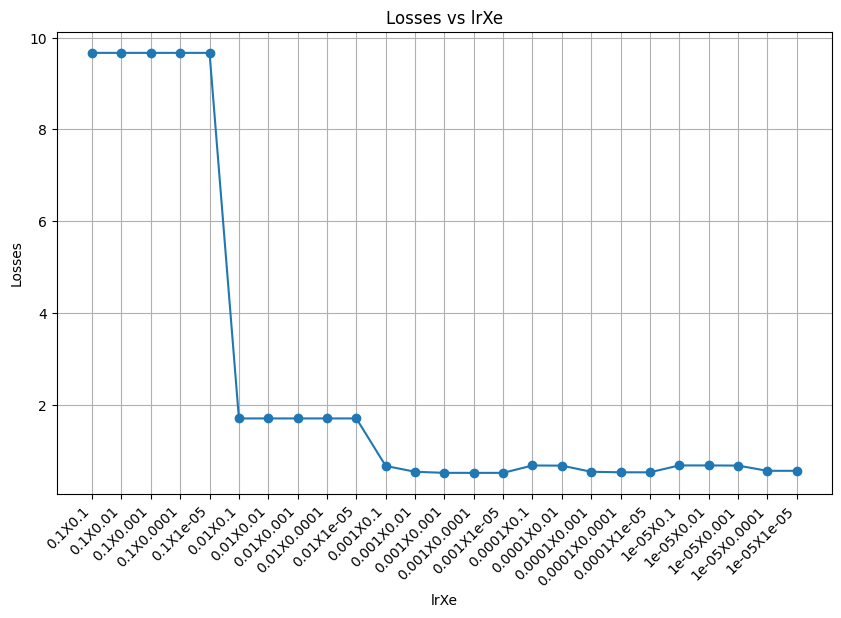

In [54]:
# List of learning rates to try
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]

# List of epsilon (early stopping criteria) values to try
epsilon = [0.1, 0.01, 0.001, 0.0001, 0.00001]

# Initialize an empty list to store the combinations of learning rates and epsilon values
lrXe = []

# Initialize an empty list to store the corresponding losses
losses = []

# Iterate over each learning rate and epsilon combination
for lr in learning_rates:
    for e in epsilon:
        # Create a string representation of the combination (e.g., "0.1X0.1")
        lrXe.append(str(lr) + "X" + str(e))

        # Instantiate a logistic regression model
        model = LogisticRegression()

        # Evaluate the model's performance for the current combination of lr and e
        loss = evaluate_learning_rate(model, X_final_train, y_train, learning_rate=lr, e=e)

        # Append the loss to the 'losses' list
        losses.append(loss)

# Create a figure for the plot
plt.figure(figsize=(10,6))

# Plot the losses against the lrXe combinations, using markers for data points
plt.plot(lrXe, losses, marker='o')

# Adding a title and labels to the plot
plt.title('Losses vs lrXe')
plt.xlabel('lrXe')
plt.ylabel('Losses')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Display grid lines on the plot
plt.grid(True)

# Show the plot
plt.show()
